In [52]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install wavefile --user

  Running setup.py bdist_wheel for wavefile ... done
  Stored in directory: /home/mpc6/.cache/pip/wheels/66/15/4d/569107ede3d4540d3b5447646a4090699cfba305a33584ecfd
Successfully built wavefile
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:

Audio(samples_nr, rate=SAMPLERATE)

In [3]:
import os, sys
import soundfile as sf
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy.io import wavfile
from scipy import signal
from librosa import power_to_db
from librosa.feature import mfcc, melspectrogram
from librosa.core import resample
from librosa.display import specshow
#import noisereduce as nr
#import wavefile
#import sounddevice as sd
#import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import thinkdsp
import subprocess
from subprocess import Popen, PIPE
#from sklearn.model_selection import train_test_split
#import pickle
# Keras packages model
#from keras.models import Sequential, Model, load_model
#from keras.layers import Input, Reshape, Dense, GRU, Convolution1D, Convolution2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Flatten, concatenate 
#from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping
#from keras import regularizers

SAMPLERATE = 8000
DATAPATH = 'data/test'


In [100]:
# Download raw data from source
# and uncompress to DATAPATH

os.makedirs(DATAPATH, exist_ok=True)

url = 'http://download.tensorflow.org/data/'
file_name = 'speech_commands_v0.01.tar.gz'

if not os.path.exists(DATAPATH):
    os.makdirs(DATAPATH)
        
if not os.path.exists(os.path.join(DATAPATH, file_name)):
    
    print('Downloading', file_name)
    rtnVal = subprocess.call(['wget', os.path.join(url,file_name), '-P', DATAPATH])
    assert rtnVal == 0, 'downloaded failed!'
    print(file_name, 'downloaded successfully')
    
    print('Uncompressing', os.path.basename(file_name))
    rtnVal = subprocess.call(['tar', '-C', DATAPATH, '-zxvf', os.path.join(DATAPATH, file_name)])
    assert rtnVal == 0, 'file failed to uncompress!'
    print(file_name, 'uncompressed successfully')

# save data at correct SAMPLERATE
for wav_file in glob.iglob(os.path.join(DATAPATH, 'bed', '*.wav')):
    print('File:', wav_file)
    samples, sample_rate = sf.read(wav_file)
    
    if sample_rate != SAMPLERATE:
        print('Resampling file ', wav_file, 'from', sample_rate, 'to', SAMPLERATE)
        samples = resample(samples, sample_rate, SAMPLERATE)
        sf.write(wav_file, samples, SAMPLERATE)    
        
print('Data downloaded and resampled to', SAMPLERATE, 'Hz')

File: data/test/bed/00176480_nohash_0.wav
Resampling file  data/test/bed/00176480_nohash_0.wav from 16000 to 8000
File: data/test/bed/004ae714_nohash_0.wav
Resampling file  data/test/bed/004ae714_nohash_0.wav from 16000 to 8000
File: data/test/bed/004ae714_nohash_1.wav
Resampling file  data/test/bed/004ae714_nohash_1.wav from 16000 to 8000
File: data/test/bed/00f0204f_nohash_0.wav
Resampling file  data/test/bed/00f0204f_nohash_0.wav from 16000 to 8000
File: data/test/bed/00f0204f_nohash_1.wav
Resampling file  data/test/bed/00f0204f_nohash_1.wav from 16000 to 8000
File: data/test/bed/012c8314_nohash_0.wav
Resampling file  data/test/bed/012c8314_nohash_0.wav from 16000 to 8000
File: data/test/bed/012c8314_nohash_1.wav
Resampling file  data/test/bed/012c8314_nohash_1.wav from 16000 to 8000
File: data/test/bed/0132a06d_nohash_0.wav
Resampling file  data/test/bed/0132a06d_nohash_0.wav from 16000 to 8000
File: data/test/bed/0135f3f2_nohash_0.wav
Resampling file  data/test/bed/0135f3f2_nohash

File: data/test/bed/106a6183_nohash_0.wav
Resampling file  data/test/bed/106a6183_nohash_0.wav from 16000 to 8000
File: data/test/bed/10ace7eb_nohash_0.wav
Resampling file  data/test/bed/10ace7eb_nohash_0.wav from 16000 to 8000
File: data/test/bed/10c6d873_nohash_0.wav
Resampling file  data/test/bed/10c6d873_nohash_0.wav from 16000 to 8000
File: data/test/bed/11321027_nohash_0.wav
Resampling file  data/test/bed/11321027_nohash_0.wav from 16000 to 8000
File: data/test/bed/118261a9_nohash_0.wav
Resampling file  data/test/bed/118261a9_nohash_0.wav from 16000 to 8000
File: data/test/bed/118261a9_nohash_1.wav
Resampling file  data/test/bed/118261a9_nohash_1.wav from 16000 to 8000
File: data/test/bed/118261a9_nohash_2.wav
Resampling file  data/test/bed/118261a9_nohash_2.wav from 16000 to 8000
File: data/test/bed/11860c84_nohash_0.wav
Resampling file  data/test/bed/11860c84_nohash_0.wav from 16000 to 8000
File: data/test/bed/11a022ba_nohash_0.wav
Resampling file  data/test/bed/11a022ba_nohash

File: data/test/bed/19f9c115_nohash_1.wav
Resampling file  data/test/bed/19f9c115_nohash_1.wav from 16000 to 8000
File: data/test/bed/19f9c115_nohash_2.wav
Resampling file  data/test/bed/19f9c115_nohash_2.wav from 16000 to 8000
File: data/test/bed/19f9c115_nohash_3.wav
Resampling file  data/test/bed/19f9c115_nohash_3.wav from 16000 to 8000
File: data/test/bed/1a073312_nohash_0.wav
Resampling file  data/test/bed/1a073312_nohash_0.wav from 16000 to 8000
File: data/test/bed/1a073312_nohash_1.wav
Resampling file  data/test/bed/1a073312_nohash_1.wav from 16000 to 8000
File: data/test/bed/1a4259c3_nohash_0.wav
Resampling file  data/test/bed/1a4259c3_nohash_0.wav from 16000 to 8000
File: data/test/bed/1a4259c3_nohash_1.wav
Resampling file  data/test/bed/1a4259c3_nohash_1.wav from 16000 to 8000
File: data/test/bed/1a5b9ca4_nohash_0.wav
Resampling file  data/test/bed/1a5b9ca4_nohash_0.wav from 16000 to 8000
File: data/test/bed/1a5b9ca4_nohash_1.wav
Resampling file  data/test/bed/1a5b9ca4_nohash

File: data/test/bed/274c008f_nohash_0.wav
Resampling file  data/test/bed/274c008f_nohash_0.wav from 16000 to 8000
File: data/test/bed/2796ac50_nohash_0.wav
Resampling file  data/test/bed/2796ac50_nohash_0.wav from 16000 to 8000
File: data/test/bed/27b03931_nohash_0.wav
Resampling file  data/test/bed/27b03931_nohash_0.wav from 16000 to 8000
File: data/test/bed/27b9a84f_nohash_0.wav
Resampling file  data/test/bed/27b9a84f_nohash_0.wav from 16000 to 8000
File: data/test/bed/283d7a53_nohash_0.wav
Resampling file  data/test/bed/283d7a53_nohash_0.wav from 16000 to 8000
File: data/test/bed/28460a60_nohash_0.wav
Resampling file  data/test/bed/28460a60_nohash_0.wav from 16000 to 8000
File: data/test/bed/28497c5b_nohash_0.wav
Resampling file  data/test/bed/28497c5b_nohash_0.wav from 16000 to 8000
File: data/test/bed/28612180_nohash_0.wav
Resampling file  data/test/bed/28612180_nohash_0.wav from 16000 to 8000
File: data/test/bed/28612180_nohash_1.wav
Resampling file  data/test/bed/28612180_nohash

File: data/test/bed/3402e488_nohash_0.wav
Resampling file  data/test/bed/3402e488_nohash_0.wav from 16000 to 8000
File: data/test/bed/3411cf4b_nohash_0.wav
Resampling file  data/test/bed/3411cf4b_nohash_0.wav from 16000 to 8000
File: data/test/bed/3411cf4b_nohash_1.wav
Resampling file  data/test/bed/3411cf4b_nohash_1.wav from 16000 to 8000
File: data/test/bed/34263ab3_nohash_0.wav
Resampling file  data/test/bed/34263ab3_nohash_0.wav from 16000 to 8000
File: data/test/bed/34263ab3_nohash_1.wav
Resampling file  data/test/bed/34263ab3_nohash_1.wav from 16000 to 8000
File: data/test/bed/34263ab3_nohash_2.wav
Resampling file  data/test/bed/34263ab3_nohash_2.wav from 16000 to 8000
File: data/test/bed/34ba417a_nohash_0.wav
Resampling file  data/test/bed/34ba417a_nohash_0.wav from 16000 to 8000
File: data/test/bed/34ba417a_nohash_1.wav
Resampling file  data/test/bed/34ba417a_nohash_1.wav from 16000 to 8000
File: data/test/bed/34ba417a_nohash_2.wav
Resampling file  data/test/bed/34ba417a_nohash

File: data/test/bed/3ff840aa_nohash_1.wav
Resampling file  data/test/bed/3ff840aa_nohash_1.wav from 16000 to 8000
File: data/test/bed/40115b19_nohash_0.wav
Resampling file  data/test/bed/40115b19_nohash_0.wav from 16000 to 8000
File: data/test/bed/402e2977_nohash_0.wav
Resampling file  data/test/bed/402e2977_nohash_0.wav from 16000 to 8000
File: data/test/bed/402e2977_nohash_1.wav
Resampling file  data/test/bed/402e2977_nohash_1.wav from 16000 to 8000
File: data/test/bed/409c962a_nohash_0.wav
Resampling file  data/test/bed/409c962a_nohash_0.wav from 16000 to 8000
File: data/test/bed/409c962a_nohash_1.wav
Resampling file  data/test/bed/409c962a_nohash_1.wav from 16000 to 8000
File: data/test/bed/409c962a_nohash_2.wav
Resampling file  data/test/bed/409c962a_nohash_2.wav from 16000 to 8000
File: data/test/bed/413997c1_nohash_0.wav
Resampling file  data/test/bed/413997c1_nohash_0.wav from 16000 to 8000
File: data/test/bed/413bcfe1_nohash_0.wav
Resampling file  data/test/bed/413bcfe1_nohash

Resampling file  data/test/bed/4c13fe25_nohash_2.wav from 16000 to 8000
File: data/test/bed/4c432947_nohash_0.wav
Resampling file  data/test/bed/4c432947_nohash_0.wav from 16000 to 8000
File: data/test/bed/4c432947_nohash_1.wav
Resampling file  data/test/bed/4c432947_nohash_1.wav from 16000 to 8000
File: data/test/bed/4c432947_nohash_2.wav
Resampling file  data/test/bed/4c432947_nohash_2.wav from 16000 to 8000
File: data/test/bed/4c4d2526_nohash_0.wav
Resampling file  data/test/bed/4c4d2526_nohash_0.wav from 16000 to 8000
File: data/test/bed/4c7c95de_nohash_0.wav
Resampling file  data/test/bed/4c7c95de_nohash_0.wav from 16000 to 8000
File: data/test/bed/4c7c95de_nohash_1.wav
Resampling file  data/test/bed/4c7c95de_nohash_1.wav from 16000 to 8000
File: data/test/bed/4c841771_nohash_0.wav
Resampling file  data/test/bed/4c841771_nohash_0.wav from 16000 to 8000
File: data/test/bed/4ca37738_nohash_0.wav
Resampling file  data/test/bed/4ca37738_nohash_0.wav from 16000 to 8000
File: data/test/

File: data/test/bed/587f3271_nohash_1.wav
Resampling file  data/test/bed/587f3271_nohash_1.wav from 16000 to 8000
File: data/test/bed/587f3271_nohash_2.wav
Resampling file  data/test/bed/587f3271_nohash_2.wav from 16000 to 8000
File: data/test/bed/589bce2c_nohash_0.wav
Resampling file  data/test/bed/589bce2c_nohash_0.wav from 16000 to 8000
File: data/test/bed/58df33b5_nohash_0.wav
Resampling file  data/test/bed/58df33b5_nohash_0.wav from 16000 to 8000
File: data/test/bed/590750e8_nohash_0.wav
Resampling file  data/test/bed/590750e8_nohash_0.wav from 16000 to 8000
File: data/test/bed/590750e8_nohash_1.wav
Resampling file  data/test/bed/590750e8_nohash_1.wav from 16000 to 8000
File: data/test/bed/591d32f3_nohash_0.wav
Resampling file  data/test/bed/591d32f3_nohash_0.wav from 16000 to 8000
File: data/test/bed/591d32f3_nohash_1.wav
Resampling file  data/test/bed/591d32f3_nohash_1.wav from 16000 to 8000
File: data/test/bed/5a0bc987_nohash_0.wav
Resampling file  data/test/bed/5a0bc987_nohash

File: data/test/bed/6366f61a_nohash_0.wav
Resampling file  data/test/bed/6366f61a_nohash_0.wav from 16000 to 8000
File: data/test/bed/637c702a_nohash_0.wav
Resampling file  data/test/bed/637c702a_nohash_0.wav from 16000 to 8000
File: data/test/bed/638548d5_nohash_0.wav
Resampling file  data/test/bed/638548d5_nohash_0.wav from 16000 to 8000
File: data/test/bed/638548d5_nohash_1.wav
Resampling file  data/test/bed/638548d5_nohash_1.wav from 16000 to 8000
File: data/test/bed/63996b7c_nohash_0.wav
Resampling file  data/test/bed/63996b7c_nohash_0.wav from 16000 to 8000
File: data/test/bed/63996b7c_nohash_1.wav
Resampling file  data/test/bed/63996b7c_nohash_1.wav from 16000 to 8000
File: data/test/bed/6414258b_nohash_0.wav
Resampling file  data/test/bed/6414258b_nohash_0.wav from 16000 to 8000
File: data/test/bed/6414258b_nohash_1.wav
Resampling file  data/test/bed/6414258b_nohash_1.wav from 16000 to 8000
File: data/test/bed/64220627_nohash_0.wav
Resampling file  data/test/bed/64220627_nohash

File: data/test/bed/6d818f6c_nohash_0.wav
Resampling file  data/test/bed/6d818f6c_nohash_0.wav from 16000 to 8000
File: data/test/bed/6d818f6c_nohash_1.wav
Resampling file  data/test/bed/6d818f6c_nohash_1.wav from 16000 to 8000
File: data/test/bed/6d818f6c_nohash_2.wav
Resampling file  data/test/bed/6d818f6c_nohash_2.wav from 16000 to 8000
File: data/test/bed/6e2ef3d5_nohash_0.wav
Resampling file  data/test/bed/6e2ef3d5_nohash_0.wav from 16000 to 8000
File: data/test/bed/6e2ef3d5_nohash_1.wav
Resampling file  data/test/bed/6e2ef3d5_nohash_1.wav from 16000 to 8000
File: data/test/bed/6e41a77e_nohash_0.wav
Resampling file  data/test/bed/6e41a77e_nohash_0.wav from 16000 to 8000
File: data/test/bed/6e916de8_nohash_0.wav
Resampling file  data/test/bed/6e916de8_nohash_0.wav from 16000 to 8000
File: data/test/bed/6f2f57c1_nohash_0.wav
Resampling file  data/test/bed/6f2f57c1_nohash_0.wav from 16000 to 8000
File: data/test/bed/6f2f57c1_nohash_1.wav
Resampling file  data/test/bed/6f2f57c1_nohash

File: data/test/bed/789e4ee7_nohash_0.wav
Resampling file  data/test/bed/789e4ee7_nohash_0.wav from 16000 to 8000
File: data/test/bed/7910d292_nohash_0.wav
Resampling file  data/test/bed/7910d292_nohash_0.wav from 16000 to 8000
File: data/test/bed/7a5530c9_nohash_0.wav
Resampling file  data/test/bed/7a5530c9_nohash_0.wav from 16000 to 8000
File: data/test/bed/7a5530c9_nohash_1.wav
Resampling file  data/test/bed/7a5530c9_nohash_1.wav from 16000 to 8000
File: data/test/bed/7add4c5f_nohash_0.wav
Resampling file  data/test/bed/7add4c5f_nohash_0.wav from 16000 to 8000
File: data/test/bed/7b2e879e_nohash_0.wav
Resampling file  data/test/bed/7b2e879e_nohash_0.wav from 16000 to 8000
File: data/test/bed/7b2e879e_nohash_1.wav
Resampling file  data/test/bed/7b2e879e_nohash_1.wav from 16000 to 8000
File: data/test/bed/7b301939_nohash_0.wav
Resampling file  data/test/bed/7b301939_nohash_0.wav from 16000 to 8000
File: data/test/bed/7be5a0f3_nohash_0.wav
Resampling file  data/test/bed/7be5a0f3_nohash

Resampling file  data/test/bed/8442ea62_nohash_1.wav from 16000 to 8000
File: data/test/bed/84999496_nohash_0.wav
Resampling file  data/test/bed/84999496_nohash_0.wav from 16000 to 8000
File: data/test/bed/84bf12ff_nohash_0.wav
Resampling file  data/test/bed/84bf12ff_nohash_0.wav from 16000 to 8000
File: data/test/bed/84d1e469_nohash_0.wav
Resampling file  data/test/bed/84d1e469_nohash_0.wav from 16000 to 8000
File: data/test/bed/84d1e469_nohash_1.wav
Resampling file  data/test/bed/84d1e469_nohash_1.wav from 16000 to 8000
File: data/test/bed/850e2222_nohash_0.wav
Resampling file  data/test/bed/850e2222_nohash_0.wav from 16000 to 8000
File: data/test/bed/850e2222_nohash_1.wav
Resampling file  data/test/bed/850e2222_nohash_1.wav from 16000 to 8000
File: data/test/bed/8523766b_nohash_0.wav
Resampling file  data/test/bed/8523766b_nohash_0.wav from 16000 to 8000
File: data/test/bed/8523766b_nohash_1.wav
Resampling file  data/test/bed/8523766b_nohash_1.wav from 16000 to 8000
File: data/test/

File: data/test/bed/8f3f252c_nohash_2.wav
Resampling file  data/test/bed/8f3f252c_nohash_2.wav from 16000 to 8000
File: data/test/bed/8f4c551f_nohash_0.wav
Resampling file  data/test/bed/8f4c551f_nohash_0.wav from 16000 to 8000
File: data/test/bed/902258bb_nohash_0.wav
Resampling file  data/test/bed/902258bb_nohash_0.wav from 16000 to 8000
File: data/test/bed/902258bb_nohash_1.wav
Resampling file  data/test/bed/902258bb_nohash_1.wav from 16000 to 8000
File: data/test/bed/90804775_nohash_0.wav
Resampling file  data/test/bed/90804775_nohash_0.wav from 16000 to 8000
File: data/test/bed/90b0b91a_nohash_0.wav
Resampling file  data/test/bed/90b0b91a_nohash_0.wav from 16000 to 8000
File: data/test/bed/91223b83_nohash_0.wav
Resampling file  data/test/bed/91223b83_nohash_0.wav from 16000 to 8000
File: data/test/bed/918a2473_nohash_0.wav
Resampling file  data/test/bed/918a2473_nohash_0.wav from 16000 to 8000
File: data/test/bed/9190045a_nohash_0.wav
Resampling file  data/test/bed/9190045a_nohash

File: data/test/bed/9a3f97f8_nohash_0.wav
Resampling file  data/test/bed/9a3f97f8_nohash_0.wav from 16000 to 8000
File: data/test/bed/9a43b64b_nohash_0.wav
Resampling file  data/test/bed/9a43b64b_nohash_0.wav from 16000 to 8000
File: data/test/bed/9a4d12fd_nohash_0.wav
Resampling file  data/test/bed/9a4d12fd_nohash_0.wav from 16000 to 8000
File: data/test/bed/9a4d12fd_nohash_1.wav
Resampling file  data/test/bed/9a4d12fd_nohash_1.wav from 16000 to 8000
File: data/test/bed/9a69672b_nohash_0.wav
Resampling file  data/test/bed/9a69672b_nohash_0.wav from 16000 to 8000
File: data/test/bed/9a7c1f83_nohash_0.wav
Resampling file  data/test/bed/9a7c1f83_nohash_0.wav from 16000 to 8000
File: data/test/bed/9a7c1f83_nohash_1.wav
Resampling file  data/test/bed/9a7c1f83_nohash_1.wav from 16000 to 8000
File: data/test/bed/9aa21fa9_nohash_0.wav
Resampling file  data/test/bed/9aa21fa9_nohash_0.wav from 16000 to 8000
File: data/test/bed/9aa5439d_nohash_0.wav
Resampling file  data/test/bed/9aa5439d_nohash

Resampling file  data/test/bed/a4e8a997_nohash_1.wav from 16000 to 8000
File: data/test/bed/a50a98d2_nohash_0.wav
Resampling file  data/test/bed/a50a98d2_nohash_0.wav from 16000 to 8000
File: data/test/bed/a518d1cf_nohash_0.wav
Resampling file  data/test/bed/a518d1cf_nohash_0.wav from 16000 to 8000
File: data/test/bed/a518d1cf_nohash_1.wav
Resampling file  data/test/bed/a518d1cf_nohash_1.wav from 16000 to 8000
File: data/test/bed/a518d1cf_nohash_2.wav
Resampling file  data/test/bed/a518d1cf_nohash_2.wav from 16000 to 8000
File: data/test/bed/a527cb3c_nohash_0.wav
Resampling file  data/test/bed/a527cb3c_nohash_0.wav from 16000 to 8000
File: data/test/bed/a527cb3c_nohash_1.wav
Resampling file  data/test/bed/a527cb3c_nohash_1.wav from 16000 to 8000
File: data/test/bed/a5609cce_nohash_0.wav
Resampling file  data/test/bed/a5609cce_nohash_0.wav from 16000 to 8000
File: data/test/bed/a5d485dc_nohash_0.wav
Resampling file  data/test/bed/a5d485dc_nohash_0.wav from 16000 to 8000
File: data/test/

File: data/test/bed/b1114e4f_nohash_0.wav
Resampling file  data/test/bed/b1114e4f_nohash_0.wav from 16000 to 8000
File: data/test/bed/b12bef84_nohash_0.wav
Resampling file  data/test/bed/b12bef84_nohash_0.wav from 16000 to 8000
File: data/test/bed/b12bef84_nohash_1.wav
Resampling file  data/test/bed/b12bef84_nohash_1.wav from 16000 to 8000
File: data/test/bed/b12bef84_nohash_2.wav
Resampling file  data/test/bed/b12bef84_nohash_2.wav from 16000 to 8000
File: data/test/bed/b1426003_nohash_0.wav
Resampling file  data/test/bed/b1426003_nohash_0.wav from 16000 to 8000
File: data/test/bed/b15fc37d_nohash_0.wav
Resampling file  data/test/bed/b15fc37d_nohash_0.wav from 16000 to 8000
File: data/test/bed/b16f2d0d_nohash_0.wav
Resampling file  data/test/bed/b16f2d0d_nohash_0.wav from 16000 to 8000
File: data/test/bed/b1df80c0_nohash_0.wav
Resampling file  data/test/bed/b1df80c0_nohash_0.wav from 16000 to 8000
File: data/test/bed/b1df80c0_nohash_1.wav
Resampling file  data/test/bed/b1df80c0_nohash

File: data/test/bed/c38720cb_nohash_1.wav
Resampling file  data/test/bed/c38720cb_nohash_1.wav from 16000 to 8000
File: data/test/bed/c392e01d_nohash_0.wav
Resampling file  data/test/bed/c392e01d_nohash_0.wav from 16000 to 8000
File: data/test/bed/c4500713_nohash_0.wav
Resampling file  data/test/bed/c4500713_nohash_0.wav from 16000 to 8000
File: data/test/bed/c4cfbe43_nohash_0.wav
Resampling file  data/test/bed/c4cfbe43_nohash_0.wav from 16000 to 8000
File: data/test/bed/c4e1f6e0_nohash_0.wav
Resampling file  data/test/bed/c4e1f6e0_nohash_0.wav from 16000 to 8000
File: data/test/bed/c4f875a9_nohash_0.wav
Resampling file  data/test/bed/c4f875a9_nohash_0.wav from 16000 to 8000
File: data/test/bed/c4f875a9_nohash_1.wav
Resampling file  data/test/bed/c4f875a9_nohash_1.wav from 16000 to 8000
File: data/test/bed/c4f875a9_nohash_2.wav
Resampling file  data/test/bed/c4f875a9_nohash_2.wav from 16000 to 8000
File: data/test/bed/c4f875a9_nohash_3.wav
Resampling file  data/test/bed/c4f875a9_nohash

File: data/test/bed/ccea893d_nohash_1.wav
Resampling file  data/test/bed/ccea893d_nohash_1.wav from 16000 to 8000
File: data/test/bed/ccfd721c_nohash_0.wav
Resampling file  data/test/bed/ccfd721c_nohash_0.wav from 16000 to 8000
File: data/test/bed/cd68e997_nohash_0.wav
Resampling file  data/test/bed/cd68e997_nohash_0.wav from 16000 to 8000
File: data/test/bed/cd7f8c1b_nohash_0.wav
Resampling file  data/test/bed/cd7f8c1b_nohash_0.wav from 16000 to 8000
File: data/test/bed/cd85758f_nohash_0.wav
Resampling file  data/test/bed/cd85758f_nohash_0.wav from 16000 to 8000
File: data/test/bed/cd8b1781_nohash_0.wav
Resampling file  data/test/bed/cd8b1781_nohash_0.wav from 16000 to 8000
File: data/test/bed/cd8b1781_nohash_1.wav
Resampling file  data/test/bed/cd8b1781_nohash_1.wav from 16000 to 8000
File: data/test/bed/cd911ace_nohash_0.wav
Resampling file  data/test/bed/cd911ace_nohash_0.wav from 16000 to 8000
File: data/test/bed/ce49cb60_nohash_0.wav
Resampling file  data/test/bed/ce49cb60_nohash

File: data/test/bed/d9ae8983_nohash_0.wav
Resampling file  data/test/bed/d9ae8983_nohash_0.wav from 16000 to 8000
File: data/test/bed/d9b50b8b_nohash_0.wav
Resampling file  data/test/bed/d9b50b8b_nohash_0.wav from 16000 to 8000
File: data/test/bed/d9b50b8b_nohash_1.wav
Resampling file  data/test/bed/d9b50b8b_nohash_1.wav from 16000 to 8000
File: data/test/bed/d9b8fab2_nohash_0.wav
Resampling file  data/test/bed/d9b8fab2_nohash_0.wav from 16000 to 8000
File: data/test/bed/d9d6559e_nohash_0.wav
Resampling file  data/test/bed/d9d6559e_nohash_0.wav from 16000 to 8000
File: data/test/bed/d9e9f554_nohash_0.wav
Resampling file  data/test/bed/d9e9f554_nohash_0.wav from 16000 to 8000
File: data/test/bed/da2c5f1b_nohash_0.wav
Resampling file  data/test/bed/da2c5f1b_nohash_0.wav from 16000 to 8000
File: data/test/bed/da2c5f1b_nohash_1.wav
Resampling file  data/test/bed/da2c5f1b_nohash_1.wav from 16000 to 8000
File: data/test/bed/da4ef063_nohash_0.wav
Resampling file  data/test/bed/da4ef063_nohash

Resampling file  data/test/bed/e54a0f16_nohash_0.wav from 16000 to 8000
File: data/test/bed/e55a2b20_nohash_0.wav
Resampling file  data/test/bed/e55a2b20_nohash_0.wav from 16000 to 8000
File: data/test/bed/e55a2b20_nohash_1.wav
Resampling file  data/test/bed/e55a2b20_nohash_1.wav from 16000 to 8000
File: data/test/bed/e5afa9b0_nohash_0.wav
Resampling file  data/test/bed/e5afa9b0_nohash_0.wav from 16000 to 8000
File: data/test/bed/e5d2e09d_nohash_0.wav
Resampling file  data/test/bed/e5d2e09d_nohash_0.wav from 16000 to 8000
File: data/test/bed/e5d2e09d_nohash_1.wav
Resampling file  data/test/bed/e5d2e09d_nohash_1.wav from 16000 to 8000
File: data/test/bed/e5e54cee_nohash_0.wav
Resampling file  data/test/bed/e5e54cee_nohash_0.wav from 16000 to 8000
File: data/test/bed/e649aa92_nohash_0.wav
Resampling file  data/test/bed/e649aa92_nohash_0.wav from 16000 to 8000
File: data/test/bed/e6515415_nohash_0.wav
Resampling file  data/test/bed/e6515415_nohash_0.wav from 16000 to 8000
File: data/test/

File: data/test/bed/efa16ffd_nohash_1.wav
Resampling file  data/test/bed/efa16ffd_nohash_1.wav from 16000 to 8000
File: data/test/bed/f00180d0_nohash_0.wav
Resampling file  data/test/bed/f00180d0_nohash_0.wav from 16000 to 8000
File: data/test/bed/f06190c1_nohash_0.wav
Resampling file  data/test/bed/f06190c1_nohash_0.wav from 16000 to 8000
File: data/test/bed/f0ae7203_nohash_0.wav
Resampling file  data/test/bed/f0ae7203_nohash_0.wav from 16000 to 8000
File: data/test/bed/f0ebef1b_nohash_0.wav
Resampling file  data/test/bed/f0ebef1b_nohash_0.wav from 16000 to 8000
File: data/test/bed/f0edc767_nohash_0.wav
Resampling file  data/test/bed/f0edc767_nohash_0.wav from 16000 to 8000
File: data/test/bed/f104f742_nohash_0.wav
Resampling file  data/test/bed/f104f742_nohash_0.wav from 16000 to 8000
File: data/test/bed/f104f742_nohash_1.wav
Resampling file  data/test/bed/f104f742_nohash_1.wav from 16000 to 8000
File: data/test/bed/f104f742_nohash_2.wav
Resampling file  data/test/bed/f104f742_nohash

Resampling file  data/test/bed/f9af823e_nohash_0.wav from 16000 to 8000
File: data/test/bed/f9af823e_nohash_1.wav
Resampling file  data/test/bed/f9af823e_nohash_1.wav from 16000 to 8000
File: data/test/bed/f9bdf10e_nohash_0.wav
Resampling file  data/test/bed/f9bdf10e_nohash_0.wav from 16000 to 8000
File: data/test/bed/f9bdf10e_nohash_1.wav
Resampling file  data/test/bed/f9bdf10e_nohash_1.wav from 16000 to 8000
File: data/test/bed/f9ebdba0_nohash_0.wav
Resampling file  data/test/bed/f9ebdba0_nohash_0.wav from 16000 to 8000
File: data/test/bed/f9ebdba0_nohash_1.wav
Resampling file  data/test/bed/f9ebdba0_nohash_1.wav from 16000 to 8000
File: data/test/bed/f9f9751d_nohash_0.wav
Resampling file  data/test/bed/f9f9751d_nohash_0.wav from 16000 to 8000
File: data/test/bed/fa446c16_nohash_0.wav
Resampling file  data/test/bed/fa446c16_nohash_0.wav from 16000 to 8000
File: data/test/bed/fa446c16_nohash_1.wav
Resampling file  data/test/bed/fa446c16_nohash_1.wav from 16000 to 8000
File: data/test/

8000 8000
(128, 16)


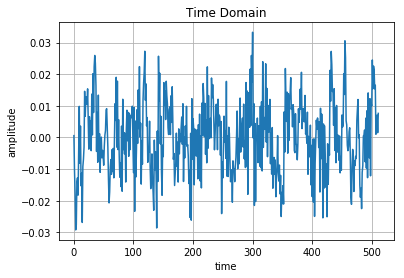

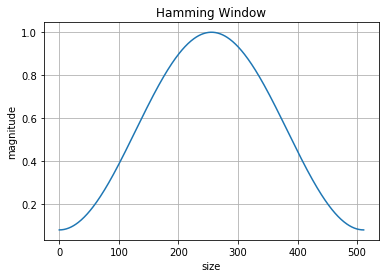

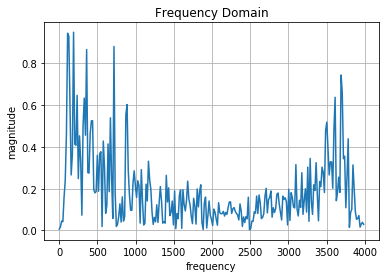

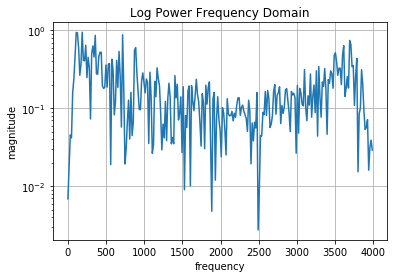

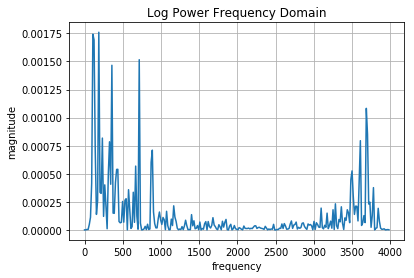

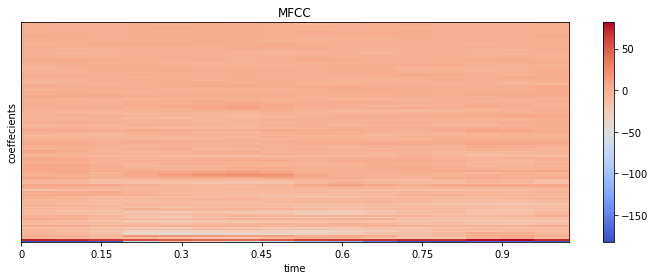

NameError: name 'samples_nr' is not defined

In [18]:
wave_file = 'data/no/9db2bfe9_nohash_0.wav'
wave_file = 'data/yes/9b6c08ba_nohash_2.wav'
wave_file = 'data/test/bed/01b4757a_nohash_0.wav'

samples, sample_rate = sf.read(wave_file)

# if sample_rate != SAMPLERATE:
#     print(sample_rate)
#     samples = resample(samples, sample_rate, SAMPLERATE)
    
# pre_emphasis
pre_emphasis = 0.97
emphasized_samples = signal.lfilter(  [1],[1, pre_emphasis], samples )



#noise = emphasized_samples[:1000] + emphasized_samples[-1000:]
#samples_nr = nr.reduce_noise(audio_clip=emphasized_samples, noise_clip=noise, verbose=True)

plt.figure()
plt.title('Time Domain')
plt.plot(emphasized_samples[:512])
plt.xlabel('time')
plt.ylabel('amplitude')
plt.grid(True)

plt.figure()
plt.title('Hamming Window')
plt.plot(np.hamming(512))
plt.xlabel('size')
plt.ylabel('magnitude')
plt.grid(True)

# Convert to FFTs and power spectrum
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(emphasized_samples[:512], NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
#print(pow_frames.shape)
freqs = np.arange(0, NFFT//2+1, dtype='float64') * ((SAMPLERATE/2)/(NFFT//2+1))

# show FFT mag
plt.figure()
plt.title('Frequency Domain')
plt.plot(freqs, mag_frames)
plt.xlabel('frequency')
plt.ylabel('magnitude')
#plt.yscale('log')
plt.grid(True)
# show FFT mag
plt.figure()
plt.title('Log Power Frequency Domain')
plt.plot(freqs, mag_frames)
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.yscale('log')
plt.grid(True)
# show FFT mag
plt.figure()
plt.title('Log Power Frequency Domain')
plt.plot(freqs, pow_frames)
plt.xlabel('frequency')
plt.ylabel('magnitude')
#plt.yscale('log')
plt.grid(True)
#plt.figure()
#plt.plot(samples_nr)
#plt.xlabel('time')
#plt.ylabel('amplitude')
#plt.grid(True)

# get MFCCs
print(len(samples), sample_rate)
S = melspectrogram(y=samples, sr=sample_rate)
mfccs = mfcc(y=samples, sr= sample_rate, n_mfcc=128)
print(mfccs.shape)
plt.figure(figsize=(10, 4))
specshow(mfccs, x_axis='time', sr=sample_rate)
plt.colorbar()
plt.title('MFCC')
plt.xlabel('time')
plt.ylabel('coeffecients')
plt.tight_layout()
plt.show()

#Audio(samples, rate=SAMPLERATE)
Audio(samples_nr, rate=SAMPLERATE)

[ 3.05175781e-05  1.52587891e-04  3.05175781e-05 ... -2.44140625e-04
 -1.83105469e-04  0.00000000e+00]
[ 3.05175781e-05  1.22985840e-04 -8.87786865e-05 ... -5.61692507e-05
 -1.28621296e-04  1.24762657e-04]
(128, 16)
(40, 16)


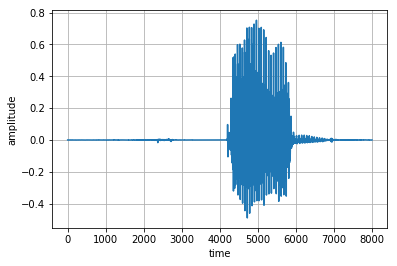

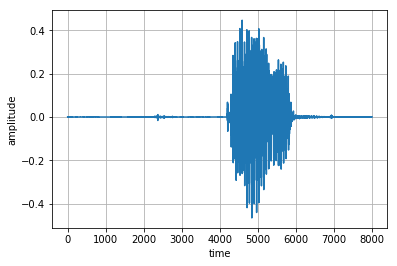

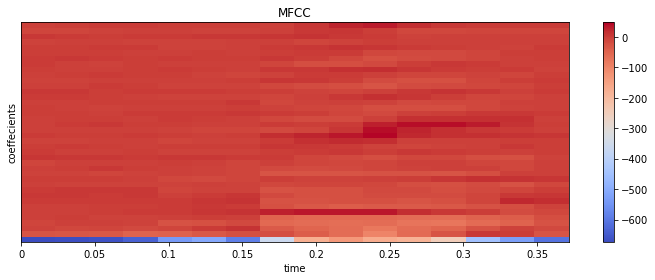

In [101]:
wave_file = 'data/test/bed/00176480_nohash_0.wav'
#wave_file = 'data/no/9db2bfe9_nohash_0.wav'
#wave_file = 'data/yes/9b6c08ba_nohash_2.wav'
samples, sample_rate = sf.read(wave_file)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)
Audio(samples, rate=SAMPLERATE)

pre_emphasis = 0.97  # coeffecient for pre-emphasis filter, boost high end for cleaner FFT
emphasized_samples = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])
# pre_emphasis
proc_samples = signal.lfilter(  [1],[1, pre_emphasis], samples )
# post_emphasis
#proc_samples = signal.lfilter( [1, pre_emphasis], [1], samples )
print(samples)
print(proc_samples)

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(emphasized_samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)


# get MFCCs
S = melspectrogram(y=samples, sr=sample_rate)
print(S.shape)
mfccs = mfcc(emphasized_samples, n_mfcc=40)
print(mfccs.shape)
plt.figure(figsize=(10, 4))
specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('time')
plt.ylabel('coeffecients')
plt.tight_layout()
plt.show()

Audio(proc_samples, rate=SAMPLERATE)

/home/mpc6/.local/lib/python3.5/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


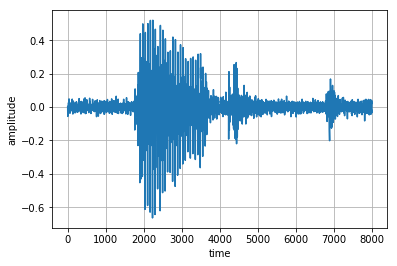

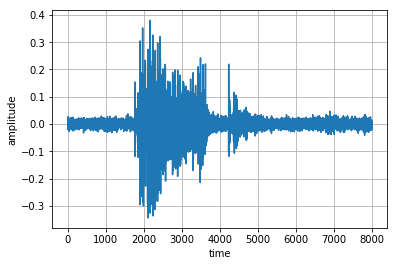

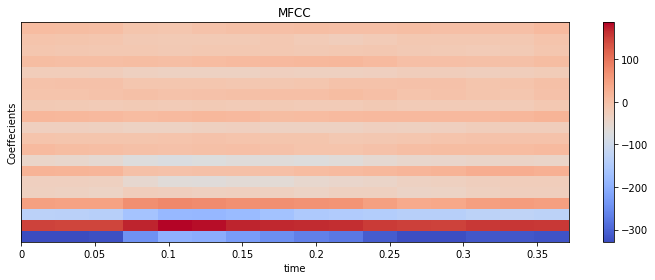

In [102]:
wave_file = 'data/yes/9b6c08ba_nohash_2.wav'
wave_file = 'data/test/bed/01b4757a_nohash_0.wav'
samples, sample_rate = sf.read(wave_file)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)
Audio(samples, rate=SAMPLERATE)

pre_emphasis = 0.97  # coeffecient for pre-emphasis filter, boost high end for cleaner FFT
emphasized_samples = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(emphasized_samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)


# get MFCCs
S = melspectrogram(y=emphasized_samples, sr=sample_rate, n_mels=128, fmax=8000)
mfccs = mfcc(S=power_to_db(S), n_mfcc=20)
plt.figure(figsize=(10, 4))
specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('time')
plt.ylabel('Coeffecients')
plt.tight_layout()
plt.show()

Audio(emphasized_samples, rate=SAMPLERATE)

Sample Rate: 8000
Num Samples: 8000


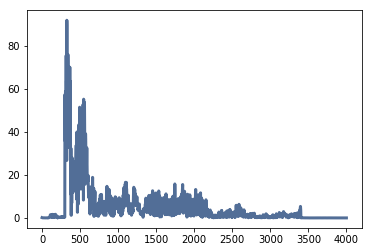

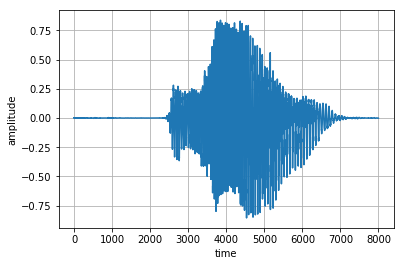

In [9]:
#Examine a wave's spectrum
high_cutoff = 3400
low_cutoff = 300

#waveFile = 'data/trainingNums/05_620a81c69b-VAD.wav'
wave_file = 'data/test/bed/00176480_nohash_0.wav'
samples, sample_rate = sf.read(wave_file)
print('Sample Rate:', sample_rate)
print('Num Samples:', len(samples))

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)
    
plt.figure()
sample = thinkdsp.read_wave(wave_file)
spectrum = sample.make_spectrum()
spectrum.low_pass(cutoff=high_cutoff, factor=0.01)
spectrum.high_pass(cutoff=low_cutoff, factor=0.01)

spectrum.plot()
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

Audio(samples, rate=SAMPLERATE)




(82, 192)
(40, 257)
[  0.   2.   4.   6.   9.  11.  14.  17.  20.  23.  26.  29.  33.  37.
  41.  45.  49.  53.  58.  63.  68.  74.  79.  85.  91.  98. 105. 112.
 119. 127. 135. 144. 153. 162. 172. 183. 194. 205. 217. 229. 242. 256.]
(82, 40)


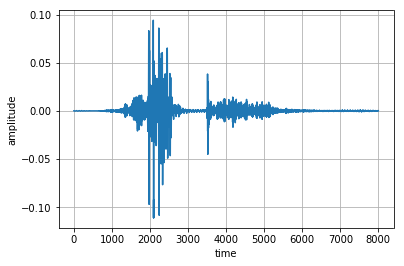

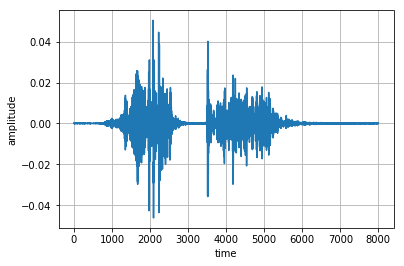

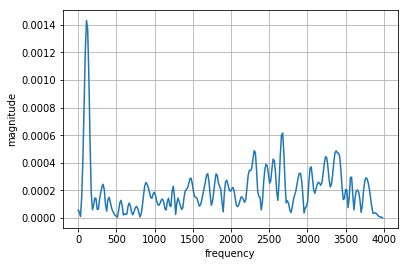

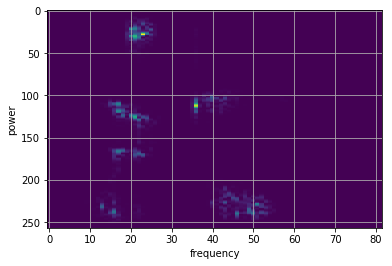

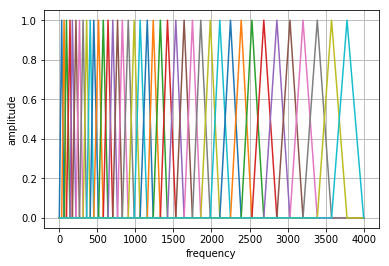

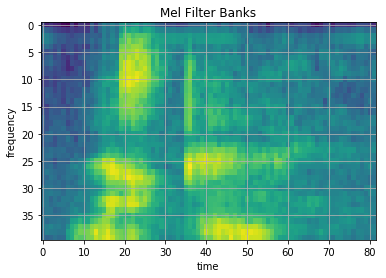

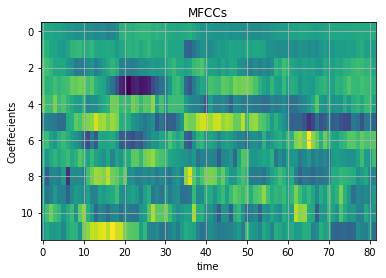

In [20]:
wave_file = 'data/bed/9d050657_nohash_1.wav'
wave_file = 'data/six/cc6ee39b_nohash_4.wav'
samples, sample_rate = sf.read(wave_file)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)
    
#sample_rate, samples = scipy.io.wavfile.read(wave_file)  # File assumed to be in the same directory

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(samples)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)
Audio(samples, rate=SAMPLERATE)

pre_emphasis = 0.97  # coeffecient for pre-emphasis filter, boost high end for cleaner FFT
emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

# test pre-empahsis filter (view and hear)
plt.figure()
plt.plot(emphasized_signal)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)
Audio(emphasized_signal, rate=SAMPLERATE)

# set up frames for FFTs 
frame_size = 0.024
frame_stride = frame_size/2

signal_length = len(emphasized_signal)
frame_length = int(round(frame_size * SAMPLERATE))
frame_step = int(round(frame_stride * SAMPLERATE))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)/frame_step)))

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
print(frames.shape)
# windowing
frames *= np.hamming(frame_length)

# Convert to FFTs and power spectrum
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
#print(pow_frames.shape)
freqs = np.arange(0, len(mag_frames[0]), dtype='float64') * ((SAMPLERATE/2)/len(mag_frames[0]))

# show FFT mag
plt.figure()
plt.plot(freqs, mag_frames[0])
plt.xlabel('frequency')
plt.ylabel('magnitude')
#plt.yscale('log')
plt.grid(True)

# show power spectrum
plt.figure()
plt.imshow(pow_frames.T, aspect='auto')
plt.xlabel('frequency')
plt.ylabel('power')
#plt.yscale('log')
plt.grid(True)

# mel filter banks
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (SAMPLERATE / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / SAMPLERATE)
#print(mel_points)
#print(hz_points)
#print(bin.shape)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
print(fbank.shape)

print(bin)
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
#print(fbank.shape)
filter_banks = np.dot(pow_frames, fbank.T)
#print(filter_banks.shape)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

# mean normalization for mel filter banks
#filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
print(filter_banks.shape)
# show banks
plt.figure()
xdata = np.array((range(NFFT//2+1)), dtype='float')
xdata *= SAMPLERATE/NFFT
for i in range(fbank.shape[0]):
    plt.plot(xdata, fbank[i,:])
#plt.plot(fbank)
plt.xlabel('frequency')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

# show mel filter banks
plt.figure()
plt.title('Mel Filter Banks')
plt.imshow(filter_banks.T, aspect='auto')
plt.xlabel('time')
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)

# get MFCCs
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

# sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
cep_lifter = 22
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

# mean normalization for MFCCs
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

# show MFCCs
plt.figure()
plt.title('MFCCs')
plt.imshow(mfcc.T, aspect='auto')
plt.xlabel('time')
plt.ylabel('Coeffecients')
#plt.yscale('log')
plt.grid(True)

In [30]:
print(SAMPLERATE)

8000


In [3]:
wave_file = 'data/bed/9d050657_nohash_1.wav'
samples, sample_rate = sf.read(wave_file)

if sample_rate != SAMPLERATE:
    samples = resample(samples, sample_rate, SAMPLERATE)

pre_emphasis = 0.97  # coeffecient for pre-emphasis filter, boost high end for cleaner FFT
emphasized_signal = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

Audio(emphasized_signal, rate=SAMPLERATE)

In [ ]:
frame_size = 0.025
frame_stride = 0.01

signal_length = len(emphasized_signal)
frame_length = int(round(frame_size * SAMPLERATE))
frame_step = int(round(frame_stride * SAMPLERATE))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)/frame_step)))

8000
8000


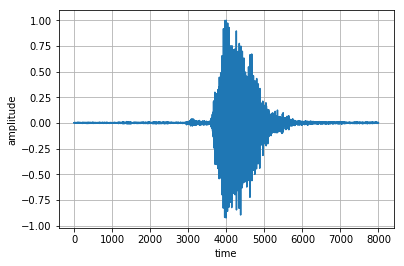

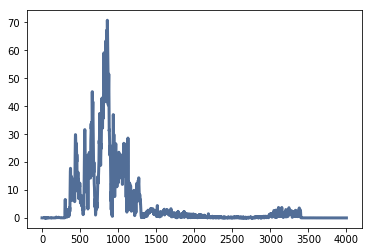

In [84]:
# load a wave, plot and play
fileName = 'data/filteredNums/12_cc5336bbc0.wav' 
#fileName = 'data/trainingNums/06_1507906720.wav'
fileName = 'data/tst_numbers_test2/cb2b6b25ca.wav'
#fileName = 'data/trainingNums2/12_a398641269.wav'
#fileName = 'data/trainingNums4/11_817144b701.wav'
#fileName = 'data/numbers/11_5589b5726b.wav'

data, sample_rate = sf.read(fileName)
print(sample_rate)
print(len(data))
duration = len(data)//5
#print(duration)
#print(max(data), min(data))
# test clip from max energy out
#maxEnergy = np.argmax(data)
#data = data[maxEnergy-(SAMPLERATE//2):maxEnergy+(SAMPLERATE//2)]
#print('new num samples', len(data))
frameSize = 6000
#data = highest_energy_frame(data, frameSize)
#print(len(data))

plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

plt.figure()
sample = thinkdsp.read_wave(fileName)
spectrum = sample.make_spectrum()
spectrum.plot()
#mags = abs(np.real(np.fft.rfft(data[:duration])))
#print(mags.shape)
#plt.figure()
#plt.plot(mags)
#plt.xlabel('freq')
#plt.ylabel('amplitude')
#plt.yscale('log')
#plt.grid(True)

#clippedSamples = clip_audio(data)
Audio(data, rate=sample_rate)